## **2. Portfolio construction**

**OVERVIEW**
- This notebook uses the processed historical dataset (`asset_universe.csv`) as the starting point.
- The goal is to compute daily log-returns per asset, build a preliminary portfolio return series, define initial weights and derive first-order KPIs.
- **Logarithmic returns** are used for **statistical validation**, as they are time-additive and mathematically more stable under compounding for distribution analysis.
- **Arithmetic (simple) returns** are used for **portfolio and capital evolution**, since they correctly replicate real investment performance over time (e.g. equity curve, drawdown, compounding).
- Cross-sectional **z-scores** (based on mean and standard deviation) are applied to compare assets and highlight unusual behaviour; robust alternatives (e.g. median/MAD) are left as a potential refinement.

**SUMMARY RESULTS**

- Most assets exhibit stable statistical behaviour, with return distributions broadly consistent with their respective asset classes.
- A small subset — notably **SPY**, **USO** and **UNG** — displays non-Gaussian characteristics, including heavy tails (`kurtosis > 10`), asymmetric returns and, in the case of **UNG**, atypical average returns and elevated volatility.
- The baseline **equally weighted, long-only portfolio** delivered a **total return of +26.42%**, with an **annualised return of 4.00%** and **annualised volatility of 12.27%**, resulting in a **Sharpe ratio of 0.19** (using the 13-week US T-Bill rate as a proxy for the risk-free rate).
- The **maximum drawdown was –23.65%** over **1,507 trading days**, reflecting exposure to market stress and the inclusion of highly volatile commodity-linked instruments.
- These results provide a baseline reference before proceeding to risk analysis and portfolio optimisation.

#### **2.1 Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import cast
from matplotlib.ticker import FuncFormatter
from src.helpers_io import read_csv_processed

#### **2.2 Loading `asset_universe.csv`**

In [2]:
# Loading processed data
asset_universe = read_csv_processed("asset_universe.csv", parse_dates=["Date"]).set_index("Date").sort_index()
risk_free = read_csv_processed("risk_free.csv", parse_dates=["Date"]).set_index("Date").sort_index()

# Displaying data
display(risk_free)
display(asset_universe)

,IRX
Date,
2019-01-02,2.365
2019-01-03,2.355
2019-01-04,2.358
2019-01-07,2.353
2019-01-08,2.400
...,...
2024-12-23,4.215
2024-12-24,4.200
2024-12-26,4.215


,EURUSD,GLD,IEF,SPY,UNG,USDJPY,USO
Date,,,,,,,
2019-01-02,1.146171,121.330002,88.567047,224.995316,97.959999,109.667999,78.800003
2019-01-03,1.131811,122.430000,89.271088,219.626282,96.839996,107.441002,79.599998
2019-01-04,1.139108,121.440002,88.550110,226.982834,100.360001,107.807999,81.440002
2019-01-07,1.141044,121.860001,88.304131,228.772537,97.519997,108.522003,82.320000
2019-01-08,1.147974,121.529999,88.083626,230.921967,98.959999,108.615997,84.000000
...,...,...,...,...,...,...,...
2024-12-23,1.043308,240.960007,88.481308,587.787476,15.630000,156.533005,73.059998
2024-12-24,1.040583,241.440002,88.529320,594.320740,16.139999,157.164993,73.650002
2024-12-26,1.039955,243.070007,88.596474,594.360413,15.370000,157.132996,73.129997


#### **2.3 Calculating log returns per asset**

Daily returns are computed using the logarithmic formula:

$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Log returns are preferred in quantitative finance because they are time-additive and provide better statistical stability under compounding

In [3]:
# Computing log returns
log_returns_raw = cast(pd.DataFrame, np.log(asset_universe / asset_universe.shift(1)))
log_returns_raw

,EURUSD,GLD,IEF,SPY,UNG,USDJPY,USO
Date,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.012608,0.009025,0.007918,-0.024152,-0.011499,-0.020516,0.010101
2019-01-04,0.006427,-0.008119,-0.008109,0.032947,0.035704,0.003410,0.022853
2019-01-07,0.001699,0.003453,-0.002782,0.007854,-0.028706,0.006601,0.010748
2019-01-08,0.006054,-0.002712,-0.002500,0.009352,0.014658,0.000866,0.020203
...,...,...,...,...,...,...,...
2024-12-23,0.006551,-0.004720,-0.004437,0.005970,-0.015238,-0.007072,-0.000547
2024-12-24,-0.002615,0.001990,0.000542,0.011054,0.032108,0.004029,0.008043
2024-12-26,-0.000603,0.006728,0.000758,0.000067,-0.048883,-0.000204,-0.007086


#### **2.4 Checking NaNs and anomalies**

- Missing values are inspected to identify whether they result from shift operations or exceptional market events.

In [4]:
# Verifying where NaN values come from
display(log_returns_raw[log_returns_raw.isna().any(axis=1)].T)

Date,2019-01-02
EURUSD,NaN
GLD,NaN
IEF,NaN
SPY,NaN
UNG,NaN
USDJPY,NaN
USO,NaN


#### **2.5 Dropping NaNs**

In [5]:
# Clean log returns
log_returns = log_returns_raw.dropna()
display(log_returns)

,EURUSD,GLD,IEF,SPY,UNG,USDJPY,USO
Date,,,,,,,
2019-01-03,-0.012608,0.009025,0.007918,-0.024152,-0.011499,-0.020516,0.010101
2019-01-04,0.006427,-0.008119,-0.008109,0.032947,0.035704,0.003410,0.022853
2019-01-07,0.001699,0.003453,-0.002782,0.007854,-0.028706,0.006601,0.010748
2019-01-08,0.006054,-0.002712,-0.002500,0.009352,0.014658,0.000866,0.020203
2019-01-09,-0.002064,0.006398,0.000578,0.004662,0.006045,0.001472,0.051055
...,...,...,...,...,...,...,...
2024-12-23,0.006551,-0.004720,-0.004437,0.005970,-0.015238,-0.007072,-0.000547
2024-12-24,-0.002615,0.001990,0.000542,0.011054,0.032108,0.004029,0.008043
2024-12-26,-0.000603,0.006728,0.000758,0.000067,-0.048883,-0.000204,-0.007086


In [6]:
# Checking NaNs
log_returns.isna().sum()

EURUSD    0
GLD       0
IEF       0
SPY       0
UNG       0
USDJPY    0
USO       0
dtype: int64

#### **2.6 Statistical validation of log returns**

Before moving into portfolio construction and risk modelling, I perform a cross-sectional quality check on daily log-returns for all assets in the universe.

To compare assets against each other, several metrics are standardised using cross-sectional z-scores:

- `z_mean`: distance (in standard deviations) between each asset’s mean return and the cross-sectional mean of means.
- `z_std`: distance between each asset’s volatility and the cross-sectional average volatility.
- `z_skew`, `z_kurt`, `z_iqr`: analogous z-scores for skewness, kurtosis and the interquartile range.

From these metrics, I define a set of diagnostic flags:

- `low_variance`: assets in the lowest 5% of the cross-sectional standard-deviation distribution (very low volatility).
- `extreme_volatility`: assets with `|z_std| > 2` (volatility significantly higher or lower than the group).
- `extreme_mean`: assets with `|z_mean| > 2` (unusually high or low average return).
- `tail_risk`: assets with `kurtosis > 10` (very heavy tails and frequent extreme moves).
- `asymmetric_returns`: assets with `|z_skew| > 2` (markedly asymmetric return distribution).
- `flat_distribution`: assets with IQR in the lowest 10% of the cross-sectional distribution (very concentrated returns).

These flags summarise which assets behave “normally” and which warrant closer attention in the subsequent risk analysis phases.

In [7]:
# Calculating stats
stats = log_returns.agg(['mean', 'std', 'min', 'max', 'skew', 'kurtosis']).T

# Quantiles and Interquantile Range (IQR)
quantiles = log_returns.quantile(q=[0, 0.25, 0.50, 0.75, 1]).T
quantiles.columns = ["q0", "q25", "q50", "q75", "q100"]
stats = stats.merge(quantiles, left_index=True, right_index=True)
stats['iqr'] = stats['q75'] - stats['q25']

# Z-scores
stats['z_mean'] = (stats['mean'] - stats['mean'].mean()) / stats['mean'].std()
stats['z_std'] = (stats['std'] - stats['std'].mean()) / stats['std'].std()
stats['z_skew'] = (stats['skew'] - stats['skew'].mean()) / stats['skew'].std()
stats['z_kurt'] = (stats['kurtosis'] - stats['kurtosis'].mean()) / stats['kurtosis'].std()
stats['z_iqr'] = (stats['iqr'] - stats['iqr'].mean()) / stats['iqr'].std()

# Quality flags
stats["low_variance"] = stats["std"] < stats["std"].quantile(0.05)
stats["extreme_volatility"] = abs(stats["z_std"]) > 2
stats["extreme_mean"] = abs(stats["z_mean"]) > 2
stats["tail_risk"] = stats["kurtosis"] > 10
stats["asymmetric_returns"] = abs(stats["z_skew"]) > 2
stats["flat_distribution"] = stats["iqr"] < stats["iqr"].quantile(0.10)

# Functions to highlight atypical stats
def highlight_flags(row):
    flags = [
        'low_variance',
        'extreme_volatility',
        'extreme_mean',
        'tail_risk',
        'asymmetric_returns',
        'flat_distribution'
    ]
    if row[flags].any():
        return ['background-color: #6b1515'] * len(row)
    return [''] * len(row)

def highlight_zscore(val):
    if abs(val) > 2:
        return 'background-color: #74700f'
    return ''

styled_stats = (
    stats
    .style
    .apply(highlight_flags, axis=1)
    .map(highlight_zscore, subset=['z_mean', 'z_std', 'z_skew', 'z_kurt', 'z_iqr'])
)

display(styled_stats)

,mean,std,min,max,skew,kurtosis,q0,q25,q50,q75,q100,iqr,z_mean,z_std,z_skew,z_kurt,z_iqr,low_variance,extreme_volatility,extreme_mean,tail_risk,asymmetric_returns,flat_distribution
EURUSD,-0.000063,0.004510,-0.028144,0.018211,-0.138172,2.080130,-0.028144,-0.002662,-0.000040,0.002611,0.018211,0.005273,-0.137842,-0.784433,0.529280,-0.609924,-0.699316,True,False,False,False,False,True
GLD,0.000454,0.009431,-0.055190,0.047390,-0.345124,2.717528,-0.055190,-0.004515,0.000698,0.005712,0.047390,0.010228,0.774552,-0.393176,0.256394,-0.529722,-0.347557,False,False,False,False,False,False
IEF,0.000002,0.004785,-0.025392,0.026074,0.180810,2.624322,-0.025392,-0.002720,0.000000,0.002665,0.026074,0.005385,-0.023125,-0.762623,0.949888,-0.541450,-0.691303,False,False,False,False,False,False
SPY,0.000630,0.012555,-0.115886,0.086731,-0.842918,13.229364,-0.115886,-0.004416,0.000911,0.006889,0.086731,0.011305,1.084409,-0.144797,-0.399994,0.792945,-0.271062,False,False,False,True,False,False
UNG,-0.001123,0.036618,-0.173722,0.156654,-0.115191,1.307752,-0.173722,-0.022500,-0.000551,0.020140,0.156654,0.042640,-2.009323,1.768439,0.559583,-0.707109,1.953393,False,False,True,False,False,False
USDJPY,0.000242,0.005658,-0.037961,0.026689,-0.413198,4.113171,-0.037961,-0.002304,0.000449,0.003146,0.026689,0.005450,0.399335,-0.693182,0.166632,-0.354113,-0.686739,False,False,False,False,False,False
USO,-0.000034,0.027076,-0.291891,0.154151,-2.103190,22.420025,-0.291891,-0.011802,0.001471,0.013782,0.154151,0.025584,-0.088006,1.009772,-2.061782,1.949374,0.742584,False,False,False,True,True,False


#### **2.7 Statistical interpretations**

- Assets are evaluated using condition-based interpretation rules.
- If any statistical flags are triggered (e.g. high volatility, heavy tails or extreme skewness), a concise diagnostic statement is generated.
- Otherwise, the asset is classified as statistically stable and suitable for further portfolio analysis.

In [8]:
# Automating interpretations
def stats_interpretations(df: pd.DataFrame) -> pd.DataFrame:
    # DataFrame to store interpretations
    interpretations = pd.DataFrame(index=df.index, columns=["interpretation"])

    # Selecting ONLY boolean columns
    bool_cols = df.select_dtypes(include='bool').columns

    for ticker, row in df.iterrows():
        ticker = cast(str, ticker)

        # Conditions
        if row[bool_cols].any():
            pieces = []

            if row.get("extreme_volatility", False):
                pieces.append(f"High volatility (z_std = {row['z_std']:.1f})")

            if row.get("tail_risk", False):
                pieces.append(f"Heavy tails (kurt={row['kurtosis']:.1f})")

            if row.get("asymmetric_returns", False):
                pieces.append(f"Asymmetric returns (z_skew={row['z_skew']:.1f})")

            if row.get("extreme_mean", False):
                pieces.append(f"Atypical mean (z_mean={row['z_mean']:.1f})")

            if row.get("low_variance", False):
                pieces.append(f"Low variance (std={row['std']:.2%})")

            if row.get("flat_distribution", False):
                pieces.append(f"Flat distribution (z_iqr={row['z_iqr']:.1f})")

            # Joining text
            text = ". ".join(pieces)

        else:
            text = f"Steady statistical behaviour, volatility and tails within normal ranges. Good to use for further analysis"

        # Storing interpretation
        interpretations.loc[ticker, "interpretation"] = text

    return interpretations

interpretations = stats_interpretations(stats)
display(interpretations)

,interpretation
EURUSD,Low variance (std=0.45%). Flat distribution (z...
GLD,"Steady statistical behaviour, volatility and t..."
IEF,"Steady statistical behaviour, volatility and t..."
SPY,Heavy tails (kurt=13.2)
UNG,Atypical mean (z_mean=-2.0)
USDJPY,"Steady statistical behaviour, volatility and t..."
USO,Heavy tails (kurt=22.4). Asymmetric returns (z...


#### **2.8 Portfolio weights**

The baseline portfolio follows three structural assumptions:
1. **Long-only positions:** All weights are $\geq 0$
2. **No leverage:** All weights sum up to 1 (fully invested capital)
3. **Equally weighted:** Each asset receives the same capital allocation

This configuration is a standard quantitative benchmark, as it introduces no bias towards any asset and provides a neutral reference before applying risk-adjusted or optimised weighting strategies

In [9]:
# Getting ticker names to use them as index for weights
tickers = stats.index

# Computing equally weights
weights = pd.Series(1 / len(tickers), index=tickers, name="equal_weights")
display(weights)

EURUSD    0.142857
GLD       0.142857
IEF       0.142857
SPY       0.142857
UNG       0.142857
USDJPY    0.142857
USO       0.142857
Name: equal_weights, dtype: float64

#### **2.9 Portfolio returns**

Daily returns were first computed in logarithmic form and used for cross-sectional statistical validation, as log-returns are time-additive and more convenient for analysing distributional properties (e.g. skewness, kurtosis, tail risk).

At this stage, these log-returns are **converted into arithmetic (simple) returns** in order to model the portfolio using real capital evolution. The conversion is applied asset by asset as:

$$
r^{(\text{simple})}_{i,t} = e^{\,r^{(\log)}_{i,t}} - 1
$$

Once in simple-return form, the daily portfolio return at time *t* is obtained as the cross-sectional weighted sum of individual asset returns:

$$
r_{p,t} = \sum_{i=1}^{N} w_i \, r^{(\text{simple})}_{i,t}
$$

This two-step approach keeps **log-returns for robust statistical analysis** at the asset level, while **simple returns** are used to correctly reflect compounding effects when building the portfolio’s equity curve, drawdown and other performance metrics.

In [10]:
# Arithmetic (simple) returns
simple_returns = cast(pd.DataFrame, np.exp(log_returns) - 1)

# Computing portfolio returns
portfolio_returns = simple_returns.mul(weights, axis="columns").sum(axis="columns").rename("portfolio_return")
display(portfolio_returns)

Date
2019-01-03   -0.005852
2019-01-04    0.012380
2019-01-07   -0.000086
2019-01-08    0.006615
2019-01-09    0.009932
                ...   
2024-12-23   -0.002756
2024-12-24    0.007969
2024-12-26   -0.006857
2024-12-27    0.003058
2024-12-30    0.021403
Name: portfolio_return, Length: 1507, dtype: float64

#### **2.10 Portfolio equity curve**

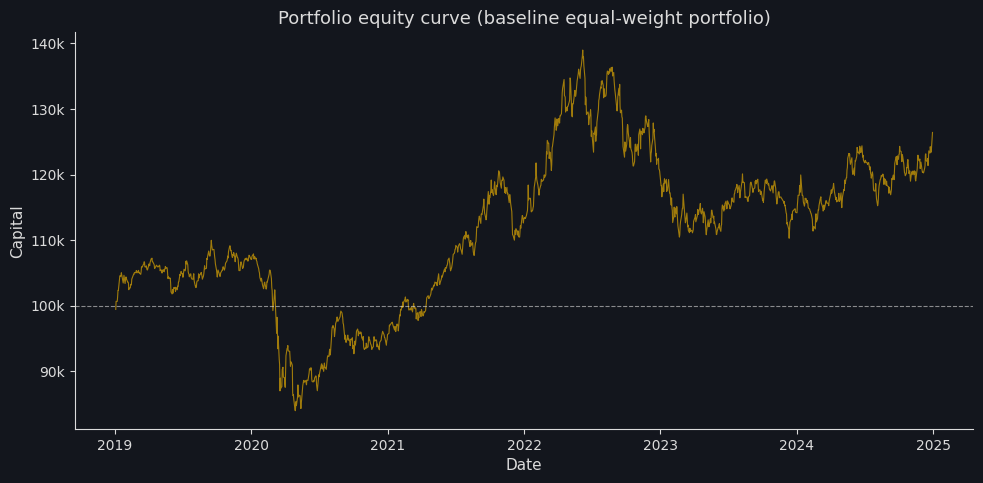

In [11]:
# Defining initial_capital
initial_capital = 100_000

# Cumulative capital over 2019-2024
equity_curve = initial_capital * (1 + portfolio_returns).cumprod()

# Font sizes
plt.rcParams.update({
    "font.size": 11,        # Baseline size
    "axes.titlesize": 13,   # Title size
    "axes.labelsize": 11,   # Axes size
    "xtick.labelsize": 10,  # X-tick size
    "ytick.labelsize": 10   # Y-tick size
})

# Creating subplots
fig, ax = plt.subplots(figsize=(10, 5))

# Customizing layout
background_color = "#13161D"
font_color = "#dbdbdb"
equity_color = "#FFC000"

fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.tick_params(axis="both", which="both", colors=font_color)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color(font_color)

# Equity line
ax.plot(equity_curve.index, equity_curve, color=equity_color, linewidth=0.8, alpha=0.6)

# Initial capital reference
ax.axhline(initial_capital, color=font_color, linestyle="--", linewidth=0.8, alpha=0.6)

# Formatting Y-axis in '100k' format
def thousands_formatter(x, pos):
    sign = "-" if x < 0 else ""
    return f"{sign}{int(abs(x) / 1_000)}k"

ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Setting labels
ax.set_xlabel("Date", color=font_color)
ax.set_ylabel("Capital", color=font_color)
ax.set_title("Portfolio equity curve (baseline equal-weight portfolio)", color=font_color)

# Plotting chart
plt.tight_layout(pad=1.2)
plt.show()

#### **2.11 Key Performance Indicators (KPIs)**

The following performance and risk metrics are computed for the baseline portfolio:

- Total and annualised returns  
- Daily and annualised volatility  
- Risk-adjusted performance via the Sharpe ratio (using a 13-week Treasury Bill as proxy for the risk-free rate)  
- Maximum drawdown and sample length (number of trading days)

The annualised 13-week T-Bill yield is converted into a daily risk-free rate using compound capitalisation:

$$
r_{\text{daily}} = (1 + r_{\text{annual}})^{1/n} - 1
$$

In [12]:
# Total return during the given period
total_return = (equity_curve.iloc[-1] / initial_capital) - 1

# Trading days and annualization factor
n_days = len(portfolio_returns)
trading_days = 252  # Typical trading days in a year

# Daily risk-free rate
rf_aligned = risk_free["IRX"].reindex(index=portfolio_returns.index).ffill().bfill()
daily_rf = (1 + (rf_aligned / 100)) ** (1 / trading_days) - 1

# Daily and annualized mean return
avg_daily_return = portfolio_returns.mean()
realized_annual_return = (1 + total_return) ** (trading_days / n_days) - 1

# Daily and annualized volatility
daily_std = portfolio_returns.std()
annual_std = daily_std * np.sqrt(trading_days)

# Excess returns (daily)
daily_excess_returns = portfolio_returns - daily_rf

# Mean and std of excess returns (daily)
avg_excess_return = daily_excess_returns.mean()
std_excess_return = daily_excess_returns.std()

# Sharpe ratio
daily_sharpe_ratio = np.nan if std_excess_return == 0 else (avg_excess_return / std_excess_return)
annual_sharpe_ratio = daily_sharpe_ratio * np.sqrt(trading_days)

# Maximum drawdown (%)
rolling_peak = equity_curve.cummax()
daily_drawdown = (equity_curve / rolling_peak) - 1
max_drawdown = daily_drawdown.min()

# Storing data
portfolio_metrics = pd.DataFrame({
    "Total return": [f"{total_return:.2%}"],
    "Annual return": [f"{realized_annual_return:.2%}"],
    "Annual std": [f"{annual_std:.2%}"],
    "Sharpe ratio": [f"{annual_sharpe_ratio:.2f}"],
    "Max drawdown": [f"{max_drawdown:.2%}"],
    "N days": [n_days]
}, index=["values"]).T

display(portfolio_metrics)

,values
Total return,26.42%
Annual return,4.00%
Annual std,12.27%
Sharpe ratio,0.19
Max drawdown,-23.65%
N days,1507
